In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

In [2]:
# This is needed to display the images.
%matplotlib inline

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

In [3]:
from utils import label_map_util

from utils import visualization_utils as vis_util

In [4]:
# What model to download.
MODEL_NAME = 'tomato_graph'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('training', 'object-detection.pbtxt')

NUM_CLASSES = 2

In [5]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [6]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [7]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [8]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
import glob
PATH_TO_TEST_IMAGES_DIR = 'test_images'
#TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, '{0:03d}.JPG'.format(i)) for i in range(0, 11) ]
TEST_IMAGE_PATHS = glob.glob('./test_images/*.JPG', recursive=True)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)
TEST_IMAGE_PATHS

['./test_images/006.JPG',
 './test_images/001.JPG',
 './test_images/003.JPG',
 './test_images/010.JPG',
 './test_images/007.JPG',
 './test_images/000.JPG',
 './test_images/005.JPG',
 './test_images/008.JPG',
 './test_images/004.JPG',
 './test_images/012.JPG',
 './test_images/002.JPG',
 './test_images/013.JPG',
 './test_images/009.JPG',
 './test_images/011.JPG']

------------------------------------------------------------------------------- ./test_images/006.JPG
0 tomato 99 0.5759864449501038 0.19377781450748444
1 tomato 99 0.272148072719574 0.6673985719680786
2 tomato 99 0.18717122077941895 0.4380698800086975
3 tomato 99 0.3633832633495331 0.7533462047576904
4 tomato 95 0.58770352602005 0.34788766503334045
5 tomato 93 0.5848718285560608 0.5019686818122864
6 tomato 91 0.2425561398267746 0.1535860188305378
7 tomato 72 0.2546265721321106 0.7542463541030884
8 tomato 65 0.2950107231736183 0.5128774791955948
9 tomato 60 0.5403792411088943 0.8045586943626404
10 tomato 36 0.2664085403084755 0.3294548988342285


/home/ikedalab/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


------------------------------------------------------------------------------- ./test_images/001.JPG
------------------------------------------------------------------------------- ./test_images/003.JPG
0 tomato 99 0.40398597717285156 0.47679078578948975
1 tomato 99 0.6312074661254883 0.49952206015586853
2 tomato 99 0.5365140438079834 0.35057613253593445
3 tomato 99 0.15129919350147247 0.24265189468860626
4 tomato 99 0.6335924863815308 0.7472606897354126
5 tomato 99 0.20068863034248352 0.5054778307676315
6 tomato 99 0.3198646008968353 0.226910799741745
7 tomato 98 0.36472710967063904 0.673363208770752
8 tomato 97 0.518016517162323 0.8881824910640717
9 tomato 39 0.38225647807121277 0.9200369119644165
------------------------------------------------------------------------------- ./test_images/010.JPG
0 tomato 99 0.34180591255426407 0.35480304062366486
1 tomato 99 0.692074179649353 0.4989761710166931
2 tomato 76 0.1505197286605835 0.7596840262413025
3 tomato 71 0.48418381810188293 0.809

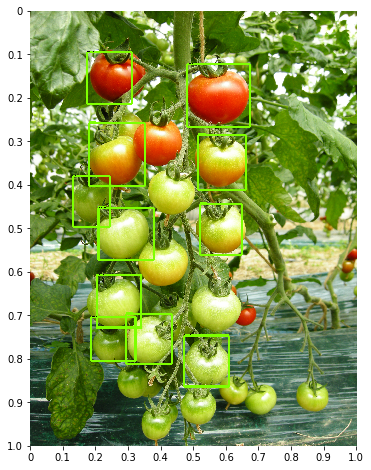

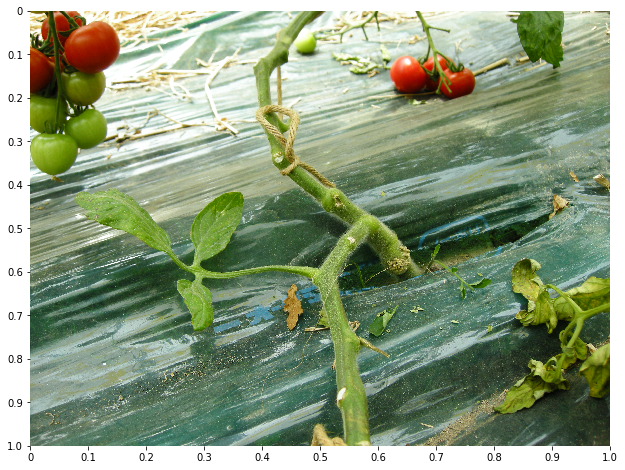

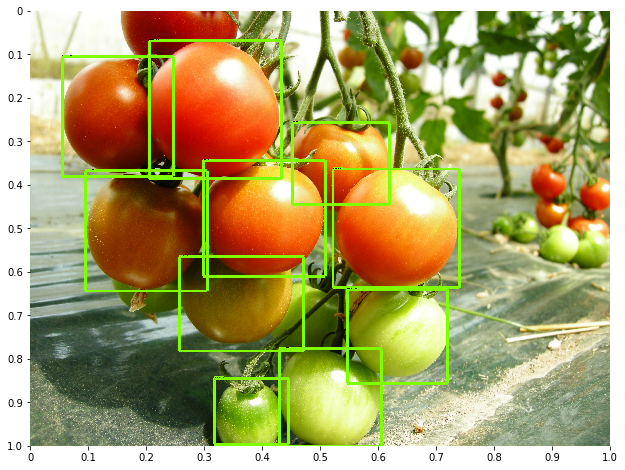

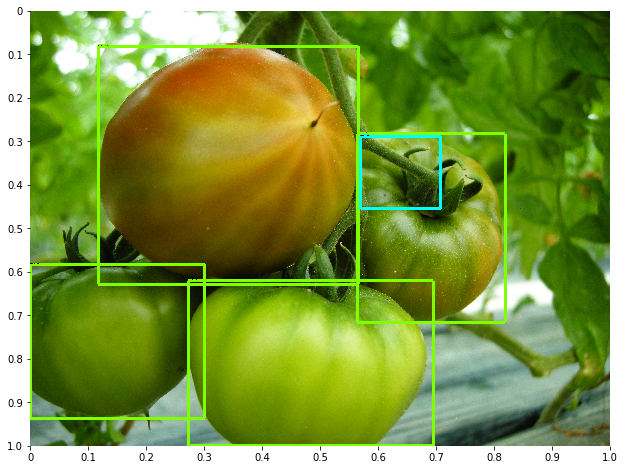

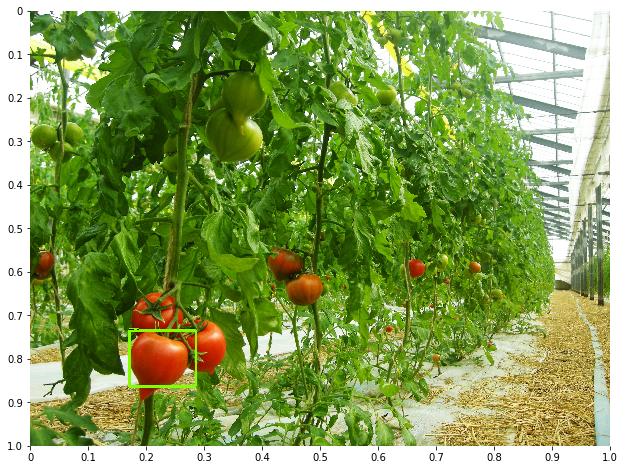

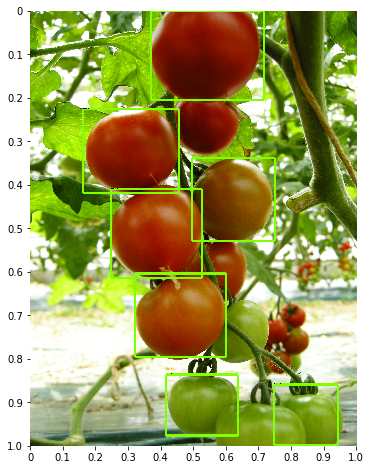

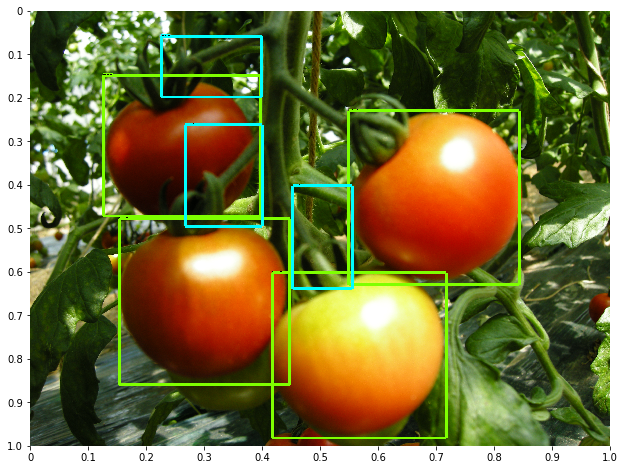

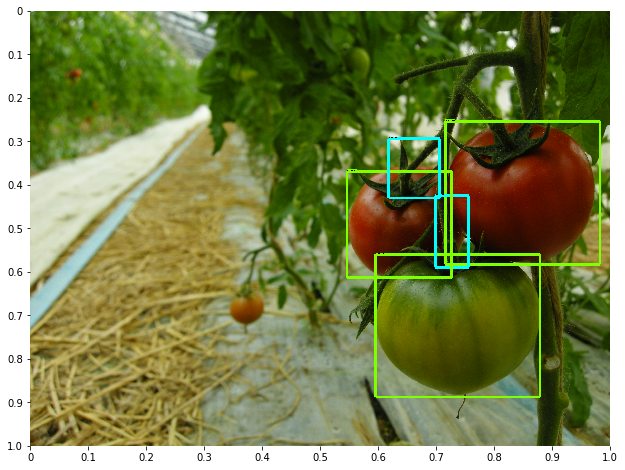

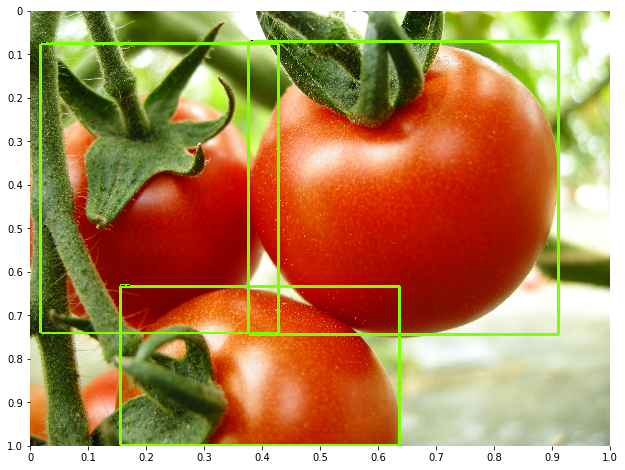

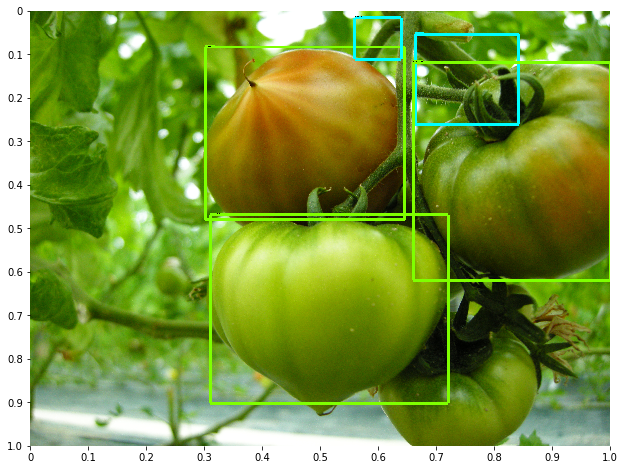

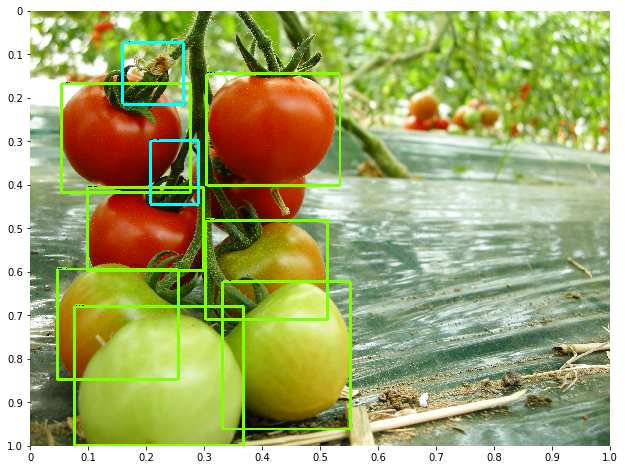

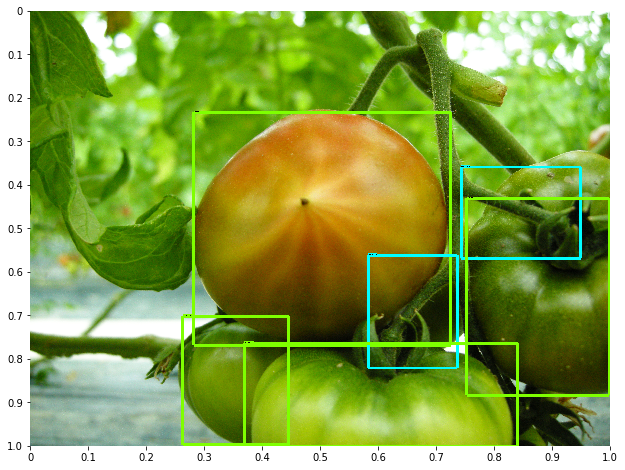

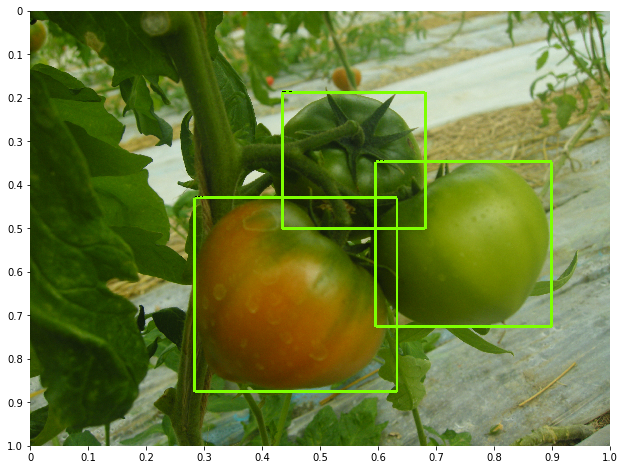

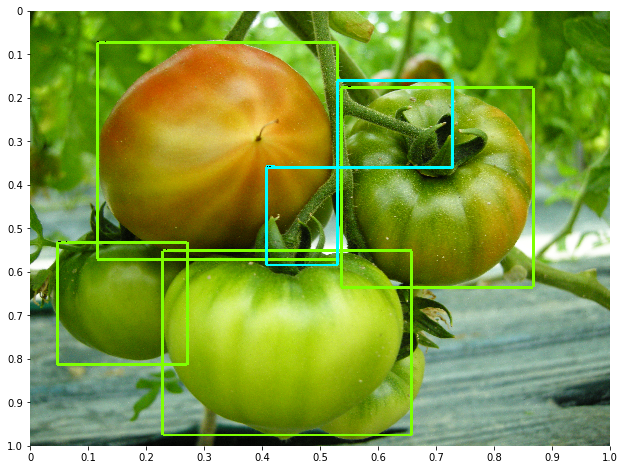

In [9]:
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    for image_path in TEST_IMAGE_PATHS:
      print("-------------------------------------------------------------------------------",image_path)  
      image = Image.open(image_path)
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
      # Each box represents a part of the image where a particular object was detected.
      boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
      # Each score represent how level of confidence for each of the objects.
      # Score is shown on the result image, together with the class label.
      scores = detection_graph.get_tensor_by_name('detection_scores:0')
      classes = detection_graph.get_tensor_by_name('detection_classes:0')
      num_detections = detection_graph.get_tensor_by_name('num_detections:0')
      # Actual detection.
      (boxes, scores, classes, num_detections) = sess.run(
          [boxes, scores, classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      # Visualization of the results of a detection.
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,

          use_normalized_coordinates=True,
          min_score_thresh=.3,
          line_thickness=20)
      plt.figure(figsize=IMAGE_SIZE)
      #plt.tick_params(labelbottom="False",bottom="False")
      #plt.tick_params(labelleft="False",left="False")
      w, h = image.size  
      plt.xticks([0,1*w/10,2*w/10,3*w/10,4*w/10,5*w/10,6*w/10,7*w/10,8*w/10,9*w/10,w], [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
      plt.yticks([0,1*h/10,2*h/10,3*h/10,4*h/10,5*h/10,6*h/10,7*h/10,8*h/10,9*h/10,h], [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
      plt.box("False")
      plt.imshow(image_np)